In [8]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np
try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
import sys
def likehoodScore(proba,y):
    return np.sum(proba * y)/proba.shape[0]


In [4]:
from custom import FootballDataHelper
#alpha, hidden size, score, weighted Score
output = []
c = FootballDataHelper(recentNum=4)
c.readFootBallData("E0_1314.csv")
c.readFootBallData("E0_1415.csv")
c.readFootBallData("E0.csv")
print(c.teamsMap)
#c.fit()
#c.fit()
#X, y = c.formatData(c.df)
#print(X)
X,y = c.getH3(5)
#X, y =c.getH3()


(380, 21)
(380, 21)
(288, 21)
{'Man City': 9, 'Liverpool': 1, 'Norwich': 2, 'Swansea': 4, 'West Brom': 5, 'Newcastle': 14, 'Arsenal': 0, 'QPR': 21, 'Man United': 19, 'Hull': 13, 'Leicester': 20, 'Everton': 11, 'Stoke': 16, 'Crystal Palace': 8, 'Burnley': 22, 'Sunderland': 3, 'Watford': 24, 'Tottenham': 18, 'Fulham': 12, 'West Ham': 6, 'Southampton': 15, 'Cardiff': 17, 'Bournemouth': 23, 'Aston Villa': 10, 'Chelsea': 7}
h3:start format
 progress 1047[ 0  1  3  6  9 12 15 18 21 24 27 30]
finish


In [5]:
print(X)
print(y.shape[0])

[[ 0.  0.  0. ...,  0.  1.  1.]
 [ 0.  0.  0. ...,  0.  1.  2.]
 [ 0.  0.  0. ...,  0.  1.  2.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  1.]
 [ 0.  0.  0. ...,  2.  1.  1.]
 [ 0.  0.  0. ...,  1.  1.  1.]]
973


In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.pipeline import Pipeline
hiddenNodes = int(3+X.shape[1]*2/3)
print(hiddenNodes)
clf = SoftMaxMLPClassifier(hidden_layer_sizes=(hiddenNodes,), activation='logistic', algorithm='l-bfgs', alpha=0.01, 
              learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=500,early_stopping = True,verbose = 3)
mlp = Pipeline([('scl', StandardScaler()),('clf', clf)])


216


/home/y/scikit-learn/sklearn/learning_curve.py:23: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [9]:
print ("start learning")
sys.stdout.flush()
train_sizes, train_scores, test_scores = learning_curve(estimator=mlp, 
                       X=X, 
                      y=y, 
                      train_sizes=np.linspace(0.1, 1.0, 4), 
                      cv=4,
                     n_jobs=1,verbose=3)
print("finishing")   
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

start learning
[learning_curve] Training set sizes: [ 72 291 510 729]
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.438525 -   1.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.352459 -   1.1s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.422131 -   1.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.381148 -   1.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.395062 -   0.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.399177 -   0.7s
[CV] no parameters to be set .........................................
[CV] ..

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   16.9s finished


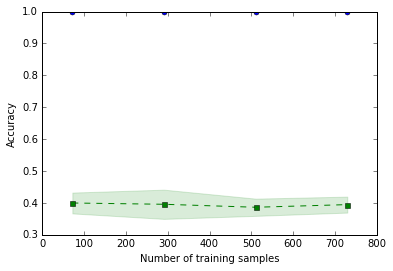

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
def plotCurve(train_mean, train_std,test_mean,test_std,sizes):
    plt.plot(train_sizes, train_mean, 
            color='blue', marker='o', 
            markersize=5, 
            label='training accuracy')
    plt.fill_between(train_sizes, 
                  train_mean + train_std,
                   train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, 
              color='green', linestyle='--', 
              marker='s', markersize=5, 
             label='validation accuracy')
    plt.fill_between(train_sizes, 
                      test_mean + test_std,
                     test_mean - test_std, 
                    alpha=0.15, color='green')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.show()
plotCurve(train_mean,train_std,test_mean,test_std,train_sizes)


In [119]:
from sklearn.cross_validation import StratifiedKFold
def crossValidate(mlp, X,y):
    y_label = np.argmax(y,axis=1)

    kfold = StratifiedKFold(y=y_label, 
                             n_folds=10,
                            random_state=1)

    scores = []
    train_scores=[]
    for k, (train, test) in enumerate(kfold):

        mlp.fit(X[train], y[train])
        score = mlp.score(X[test], y[test])
        train_scores.append(mlp.score(X[train],y[train]))
        scores.append(score)
        print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, 
                    np.bincount(y_label[train]), score))    
    return train_scores,scores



In [121]:
def lamda_test(mlp, X, y, lamdas):
    
    train_scores=[]
    test_scores=[]
    for lamda in lamdas:
        mlp.set_params(alpha= lamda)
        print(mlp.get_params())
        train_s, test_s = crossValidate(mlp,X,y)
        train_scores.append(train_s)
        test_scores.append(test_s)
        print("lamda: {}, train: {}, test: {}".format(lamda, 
                    np.mean(train_s), np.mean(test_s)) )
    return np.array(train_scores),np.array(test_scores)

l_range = np.array([0.0003,0.001,0.003,0.01,0.03,0.1,0.3])
train_scores,test_scores = lamda_test(mlp,X,y,l_range)
    

{'batch_size': 'auto', 'max_iter': 500, 'tol': 0.0001, 'power_t': 0.5, 'random_state': None, 'learning_rate_init': 0.01, 'epsilon': 1e-08, 'momentum': 0.9, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (200,), 'shuffle': True, 'verbose': 3, 'beta_2': 0.999, 'alpha': 0.00029999999999999997, 'activation': 'logistic', 'warm_start': False, 'algorithm': 'l-bfgs', 'early_stopping': True, 'nesterovs_momentum': True, 'beta_1': 0.9, 'validation_fraction': 0.1}
Fold: 1, Class dist.: [134 241 168], Acc: 0.361
Fold: 2, Class dist.: [134 241 168], Acc: 0.426
Fold: 3, Class dist.: [134 241 168], Acc: 0.426
Fold: 4, Class dist.: [134 241 168], Acc: 0.328
Fold: 5, Class dist.: [134 241 168], Acc: 0.443
Fold: 6, Class dist.: [134 241 168], Acc: 0.459
Fold: 7, Class dist.: [134 241 168], Acc: 0.426
Fold: 8, Class dist.: [134 241 169], Acc: 0.450
Fold: 9, Class dist.: [134 242 169], Acc: 0.424
Fold: 10, Class dist.: [135 242 169], Acc: 0.397
lamda: 0.0003, train: 1.0, test: 0.4139132996713647
{'batc

In [10]:
import matplotlib.pyplot as plt
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

print(train_mean.shape)
print(l_range.shape)
#plotCurve(train_mean,train_std,test_mean,test_std,l_range)
plt.plot(l_range, train_mean, 
        color='blue', marker='o', 
        markersize=5, 
        label='training accuracy')
plt.fill_between(l_range, 
              train_mean + train_std,
               train_mean - train_std, alpha=0.15, color='blue')

plt.plot(l_range, test_mean, 
          color='green', linestyle='--', 
          marker='s', markersize=5, 
         label='validation accuracy')
plt.fill_between(l_range, 
                  test_mean + test_std,
                 test_mean - test_std, 
                alpha=0.15, color='green')
plt.xlabel('lamda')
plt.ylabel('Accuracy')
plt.show()


(4,)


NameError: name 'l_range' is not defined

In [20]:
from sklearn.cross_validation import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size =0.3)



In [21]:
mlp.fit(X_train, y_train)

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SoftMaxMLPClassifier(activation='logistic', algorithm='l-bfgs', alpha=0.01,
           batch_size='auto', beta_1=0.9, beta_2=0.999,
           early_stopping=True, epsilon=1e-08, hidden_layer_sizes=(216,),
           l...e=None, shuffle=True, tol=0.0001,
           validation_fraction=0.1, verbose=3, warm_start=False))])

In [22]:
res = mlp.predict_proba(X_test)


In [23]:
predicted = mlp.predict(X_test)
print(mlp.score(X_test, y_test))

0.465753424658


In [24]:
likehoodScore(res,y_test)

0.45621771299854519

In [19]:
home_teams_test = np.argmax(X_test[:,0:len(c.teamsMap)],axis=1)
away_teams_test = np.argmax(X_test[:,len(c.teamsMap):len(c.teamsMap)*2],axis=1)
inverseMap ={}
for name in c.teamsMap.keys():        
    inverseMap[c.teamsMap[name]] = name

home_name =[]
away_name =[]
for i in range(home_teams_test.shape[0]):         
    home_name.append(inverseMap[home_teams_test[i]])
    away_name.append(inverseMap[away_teams_test[i]])
pre_y = np.argmax(predicted,axis=1)
real_y = np.argmax(y_test,axis=1)
for i in range(predicted.shape[0]):
    if pre_y[i] != real_y[i]:
        print('-------------')
        print("{} vs {}".format(home_name[i],away_name[i]))
        print("{} vs {}".format(res[i],y_test[i]))
    

-------------
Chelsea vs Stoke
[  4.09936357e-15   1.00000000e+00   5.96226083e-21] vs [ True False False]
-------------
Everton vs Sunderland
[ 0.14373453  0.69318072  0.16308475] vs [False False  True]
-------------
Southampton vs Hull
[  9.99925849e-01   7.41508422e-05   4.25533924e-10] vs [False  True False]
-------------
Aston Villa vs Crystal Palace
[  9.59398572e-01   4.38408506e-14   4.06014283e-02] vs [False False  True]
-------------
Man City vs Burnley
[  4.34166244e-11   1.00000000e+00   1.00862640e-14] vs [ True False False]
-------------
Sunderland vs Southampton
[ 0.73962941  0.25315086  0.00721973] vs [False False  True]
-------------
Crystal Palace vs West Ham
[  6.12116276e-14   9.99990772e-01   9.22831137e-06] vs [False False  True]
-------------
Swansea vs Man City
[  6.89654868e-10   9.99999999e-01   6.23996690e-11] vs [False False  True]
-------------
Leicester vs West Brom
[  9.99999996e-01   2.86064481e-09   1.04686134e-09] vs [False False  True]
-------------
S

In [17]:
#c.df[(c.df['HomeTeam'] == 'West Brom') | (c.df['AwayTeam']=='West Brom')]